### COHEN Benjamin et ORGIAZZI Aurélien

#### Projet RL : méthode Cross Entropy

Nous avons repris le code du retail store en ajoutant une méthode se basant sur la Cross Entropy. \
De plus, nous avons changé la distribution de la demande qui cette fois, suit une loi uniforme $U[0,15]$ 

 L'implémentation de la méthode CE commence à la section 7.

You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to minimize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s\right].$$

In [1]:
import numpy as np
import random as rd
import gym
from matplotlib import pyplot as plt
import time 
from more_itertools import sort_together

### Problem parameters 

In [2]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

We choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. 

In [12]:
M=15
#Distribution uniforme
uniforme = np.array([1/(M+1) for m in range(M+1)])


print("the average demand is ",np.sum([m*uniforme[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(uniforme))

the average demand is  7.5
a simulated demand is  13


### Encoding of the MDP as a gym environment

In [4]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        self.Demand_Distribution = uniforme
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? (no terminal state here) / information (optional) 
        return self.state, reward, False, {}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

In [5]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T+1)
    States = np.zeros(T+1)
    Action = np.zeros(T+1)
    env=StoreManagement(s0)
    for t in range(T):
        States[t]=env.state
        action=Pi(env.state)
        Action[t] = action
        state,rew,x,y=env.step(action)
        Rewards[t]=rew
    return States,Rewards, Action

### Running simulations with three simple baselines 

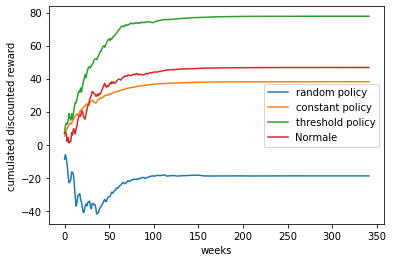

In [6]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

def Normale(s,M = 11, mu=0,sigma=3):
    action = M - s + int(np.random.randn()*sigma+mu)
    return action
        

T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum
States1,Rewards1, Action1 = SimulateTrajectory(T, PiUniform,s1)
States2,Rewards2, Action2 = SimulateTrajectory(T, PiConstant,s1)
States3,Rewards3, Action3 = SimulateTrajectory(T, PiThreshold,s1)
States4,Rewards4, Action4 = SimulateTrajectory(T, Normale, s1)

# plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(T+1)])),label="random policy")
plt.plot(np.cumsum(Rewards2*np.array([gamma**t for t in range(T+1)])),label="constant policy")
plt.plot(np.cumsum(Rewards3*np.array([gamma**t for t in range(T+1)])),label="threshold policy")
plt.plot(np.cumsum(Rewards4*np.array([gamma**t for t in range(T+1)])),label="Normale")
plt.xlabel('weeks')
plt.ylabel('cumulated discounted reward')
plt.legend()



### Ajout de la méthode CE

In [7]:
K = 10 # Nombre de runs / d'actualisation des paramètres de la loi normale
N = 100  # Number of samples
rho = 1/5  # 20%

mu = 0  # Moyenne de la loi normale
s = 1  #Variance de la loi normale

M = 11  # Seuil supérieur

T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

for k in range(K):
    R = []
    L = []
    S = []
    
    # On génère N trajectoirs avec la politique 'normale' utilisant la CE avec les paramètres mu et sigma
    for n in range(N):  
        M_list = [M for k in range (T+1)]
        def Normale(s,M = 11, mu=mu,sigma=s):
            loi = int(np.random.randn()*sigma+mu)
            action = M - s + loi
            return action
        States4,Rewards4, Action4 = SimulateTrajectory(T, Normale, s1)  # Etats, recompenses et actions d'une trajectoire
        R.append(np.sum(Rewards4*np.array([gamma**t for t in range(T+1)])))
        Loi = Action4 - M_list + States4
        L.append([np.mean(Loi), np.var(Loi)])  # On enregistre dans L les moyennes et variances de la trajectoire
    
    # On choisit les données "élites" : les 20% meilleures (en terme de récompense)
    s = sort_together([R, L], reverse = True)
    R_sort = np.array(s[0])
    L_sort = np.array(s[1])[:N*rho]  
    
    # On ajuste les paramètres mu et sigma de la loi normale en se concentrant sur les données élites
    mu = np.mean(L_sort, axis=0)[0]  
    s = np.mean(L_sort, axis=0)[1]

    print('la moyenne et la variance du bruit au bout de ', k+1, ' étapes sont : ', mu,s)



la moyenne et la variance du bruit au bout de  1  étapes sont :  -0.03640350877192983 0.8148579904928012
la moyenne et la variance du bruit au bout de  2  étapes sont :  -0.04385964912280702 0.6117873875722444
la moyenne et la variance du bruit au bout de  3  étapes sont :  -0.046198830409356725 0.4589771211654868
la moyenne et la variance du bruit au bout de  4  étapes sont :  -0.03611111111111111 0.38469486337676556
la moyenne et la variance du bruit au bout de  5  étapes sont :  -0.03464912280701755 0.3614945624294655
la moyenne et la variance du bruit au bout de  6  étapes sont :  -0.033625730994152045 0.35937724428029144
la moyenne et la variance du bruit au bout de  7  étapes sont :  -0.03304093567251463 0.35795714920830346
la moyenne et la variance du bruit au bout de  8  étapes sont :  -0.0327485380116959 0.35827006600321465
la moyenne et la variance du bruit au bout de  9  étapes sont :  -0.034649122807017554 0.35682218460380977
la moyenne et la variance du bruit au bout de  1

A la fin de l'éxecution précédente les paramètres mu et sigma sont optimisé.

In [19]:
print('La moyenne est : ', round(mu,3))
print('La variance est : ', round(s,2))

La moyenne est :  -0.034
La variance est :  0.36


##### On plot les différentes politiques

la récompense moyenne de la méthode CE est :  62
la récompense moyenne de la méthode Treshold est :  67


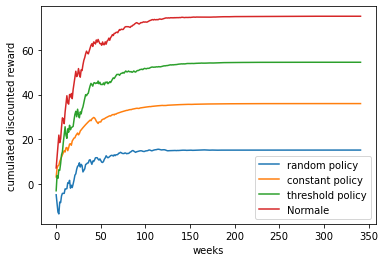

In [8]:
def Normale(s,M = 11, mu=mu,sigma=s):
    action = M - s + int(np.random.randn()*sigma+mu)
    return action

T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

States1,Rewards1, Action1 = SimulateTrajectory(T, PiUniform,s1)
States2,Rewards2, Action2 = SimulateTrajectory(T, PiConstant,s1)
States3,Rewards3, Action3 = SimulateTrajectory(T, PiThreshold,s1)
States4,Rewards4, Action4 = SimulateTrajectory(T, Normale, s1)

plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(T+1)])),label="random policy")
plt.plot(np.cumsum(Rewards2*np.array([gamma**t for t in range(T+1)])),label="constant policy")
plt.plot(np.cumsum(Rewards3*np.array([gamma**t for t in range(T+1)])),label="threshold policy")
plt.plot(np.cumsum(Rewards4*np.array([gamma**t for t in range(T+1)])),label="Normale")
plt.xlabel('weeks')
plt.ylabel('cumulated discounted reward')
plt.legend()


Norm=0
Tresh=0
for k in range (100):
    T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum
    StatesT,RewardsT, ActionT = SimulateTrajectory(T, PiThreshold,s1)
    StatesN,RewardsN, ActionN = SimulateTrajectory(T, Normale, s1)
    Norm += np.sum(RewardsN*np.array([gamma**t for t in range(T+1)]))
    Tresh += np.sum(RewardsT*np.array([gamma**t for t in range(T+1)]))
Norm=Norm/100
Tresh=Tresh/100

print('la récompense moyenne de la méthode CE est : ', int(Norm))
print('la récompense moyenne de la méthode Treshold est : ', int(Tresh))

### Evolution of the stock

Text(0.5, 1.0, 'Evolution of the stock under a normale policy')

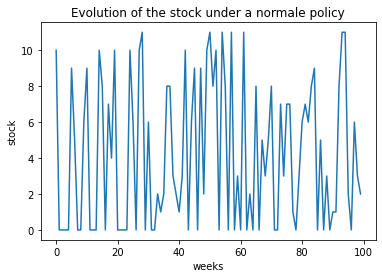

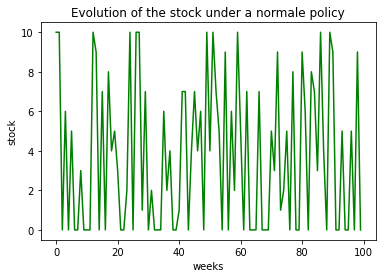

In [9]:
plt.figure()
plt.plot(States4[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a normale policy')

plt.figure()
plt.plot(States3[range(100)], color='green')
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a normale policy')

Ainsi dans la méthode de CE que nous avons implémenté, l'idée est la suivante : 
1. La politique implémentée est d'acheter un stock pour arriver à un seuil max $(M_{max})$ à $\pm \mathcal{N}(\mu,\,\sigma)$
2. On génère 100 trajectoire avec ces paramètre $\mu$ et $\sigma$
3. On met à jour les paramètres $\mu$ et $\sigma$ en prenant en compte les $\rho \% (=20\%)$ trajectoires les plus pertinentes (avec la meilleure récompense)
4. Et on re part du point 2 (K=10 fois)

Ainsi nous avons les résultats sur les courbes ci-dessus. \
On note notamment que le "bruit" tends vers une loi $\mathcal{N}(0,\,0.3)$, ce qui peut être négligeable. \
C'est pour cela que la politique de treshold simple est tout aussi efficace (voir plus lorsqu'on ajoute un seuil minimum aussi)

Finalement, notre algorithme n'est pas tout à fait optimiser car nous avons pas utilisé tous les éléments présents dans la méthode de CE, notamment le fait d'ajuster les différents tresholds ($M_{min}$ et $M_{max}$).